# Testing energy analysis file

In [4]:
# imports
from __future__ import absolute_import, print_function, unicode_literals
import numpy as np
import pandas as pd
from sklearn import linear_model
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
from sqlalchemy import create_engine

In [22]:
def get_monthly_data():
    """
    This function connects to the postgres DB to pull weather data
    corresponding to each solar location and month.
    """
    # Set up connection to postgres tables
    db_loc = 'postgresql+psycopg2://teamsunshinedemo:oscarisawesome123'
    db_loc += '@teamsunshinedemo.coga7nzsvf0h.us-east-1.rds.amazonaws.com:'
    db_loc += '5432/solarenergy'
    engine = create_engine(db_loc)

    # get weather data
    query = """
            SELECT solar_fields.loc_id as loc_id, full_date,
            CAST(solar_fields.latitude as decimal) as lat,
            CAST(solar_fields.longitude as decimal) as long,
            CAST(solar_radiation as decimal) as solar_radiation, mwh
            FROM(
                (SELECT generation.loc_id as loc_id,
                wban_id, full_date, latitude, longitude,
                CAST(mwh as decimal) AS mwh
                FROM generation JOIN closest_stations
                ON generation.loc_id=closest_stations.loc_id)
                ) AS solar_fields
            LEFT JOIN uscrn_monthly
            ON solar_fields.wban_id=uscrn_monthly.wban_id
            AND solar_fields.full_date=uscrn_monthly.month
            """
    data_df = pd.read_sql(query, engine, index_col = 'loc_id')

    return data_df

In [194]:
data_df = get_monthly_data()

In [195]:
# take a look
data_df.head()

,full_date,lat,long,solar_radiation,mwh
loc_id,,,,,
ELEC.PLANT.GEN.10441-SUN-ALL.M,200101,35.019480,-117.555530,NaN,362.0
ELEC.PLANT.GEN.10444-SUN-ALL.M,200101,35.030800,-117.356300,NaN,1228.0
ELEC.PLANT.GEN.10446-SUN-ALL.M,200101,35.033000,-117.338000,NaN,1412.0
ELEC.PLANT.GEN.10442-SUN-ALL.M,200101,35.020981,-117.566079,NaN,1351.0
ELEC.PLANT.GEN.10439-SUN-ALL.M,200101,35.006940,-117.555768,NaN,774.0


In [196]:
def data_cleaning(data_df):
    """
    This function takes a dataframe with full_date, lat, long and
    solar_radiation, splits out the month and recodes na
    values in solar radiation.
    """
    # making all types numeric and coding missing values as nan
    data_df['year'] = data_df.apply(lambda x: int(x['full_date'][:4]), axis=1)
    data_df['month'] = data_df.apply(lambda x: int(x['full_date'][4:]), axis=1)
    del data_df['full_date']
    data_df['solar_radiation'] = data_df.solar_radiation.replace(-9999.0, np.nan)
    return data_df

In [143]:
clean_df = data_cleaning(data_df)

In [55]:
# take a look:
clean_df.head()

,lat,long,solar_radiation,mwh,year,month
loc_id,,,,,,
ELEC.PLANT.GEN.10441-SUN-ALL.M,35.019480,-117.555530,NaN,362.0,2001,1
ELEC.PLANT.GEN.10444-SUN-ALL.M,35.030800,-117.356300,NaN,1228.0,2001,1
ELEC.PLANT.GEN.10446-SUN-ALL.M,35.033000,-117.338000,NaN,1412.0,2001,1
ELEC.PLANT.GEN.10442-SUN-ALL.M,35.020981,-117.566079,NaN,1351.0,2001,1
ELEC.PLANT.GEN.10439-SUN-ALL.M,35.006940,-117.555768,NaN,774.0,2001,1


In [197]:
def predict_monthly_mwh(clean_df):
    """
    Function to run a regression on the relationship between solar radiation
    levels and energy production from solar field locations. The function
    returns a new df with weather data and predictions for each solar location.

    NOTE: in future versions of this architecture this regression could be
    used as a prediction tool for locations that don't yet have solar fields.
    For that, we'd want to add additional weather variables. For now we'll
    simply explore this relationship to better inform our audience.
    """
    # remove nans
    missing = np.isnan(clean_df.solar_radiation)
    monthly_pred_df = clean_df[~missing]

    # selecting cols for regression
    #cols=['solar_radiation','month','lat']
    cols=['solar_radiation']
    X = monthly_pred_df.as_matrix(columns=cols)
    y = np.array(monthly_pred_df.mwh)

    # create and fit model
    lm = linear_model.LinearRegression()
    lm.fit(X, y)

    # add predicted values to a new dataframe column
    idx = monthly_pred_df.index
    monthly_pred_df.loc[:,'predicted_mwh'] = pd.Series(lm.predict(X), index=idx)

    # return the model for future use and predictions for serving layer
    return lm, monthly_pred_df

In [63]:
missing = np.isnan(clean_df.solar_radiation)

In [66]:
print(len(clean_df))
sum(missing)

38216


16584

In [198]:
model, monthly_pred_df = predict_monthly_mwh(clean_df)

In [145]:
monthly_pred_df.head()

,lat,long,solar_radiation,mwh,year,month,predicted_mwh
loc_id,,,,,,,
ELEC.PLANT.GEN.529-SUN-ALL.M,38.340015,-121.113861,23.9,241.0,2004,4,3769.266720
ELEC.PLANT.GEN.529-SUN-ALL.M,38.340015,-121.113861,27.9,234.0,2004,5,4566.855816
ELEC.PLANT.GEN.10444-SUN-ALL.M,35.030800,-117.356300,29.6,19249.0,2004,6,4905.831182
ELEC.PLANT.GEN.10446-SUN-ALL.M,35.033000,-117.338000,29.6,18952.0,2004,6,4905.831182
ELEC.PLANT.GEN.10441-SUN-ALL.M,35.019480,-117.555530,29.6,10447.0,2004,6,4905.831182


In [77]:
%matplotlib inline
import matplotlib.pyplot as plt

/data/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


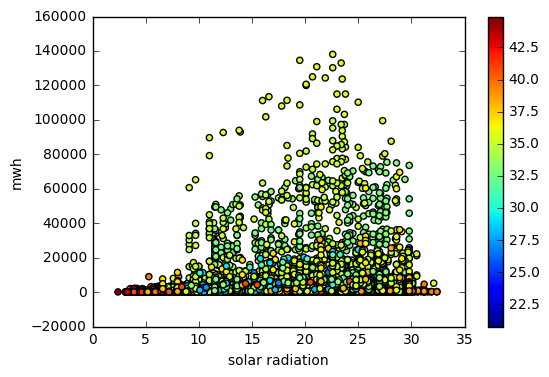

In [86]:
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(clean_df.solar_radiation, clean_df.mwh, c=clean_df.lat)
plt.xlabel('solar radiation')
plt.ylabel('mwh')
plt.colorbar(sc)
plt.show()

In [146]:
# re index for groupbys
clean_df.reset_index(level=0, inplace=True)

In [147]:
# separate out this year's data
current_year = max(clean_df.year) #2016
current_df = clean_df[clean_df.year == current_year] # 841 entries, 115 unique
current_df.reset_index(level=0, inplace=True)
current_month = max(current_df.month) #9
current_mwh = current_df.groupby(['loc_id'])['mwh'].sum() # 115

In [183]:
# how does this compare to last year at this time?
last_year = clean_df[clean_df.year == current_year - 1]
this_time_last_year = last_year[last_year.month <= current_month]
totals = last_year.groupby(['loc_id'])['mwh'].sum()
partials = this_time_last_year.groupby(['loc_id'])['mwh'].sum()
percent = totals / partials

In [188]:
forcast_df = current_mwh * percent

In [192]:
forcast_df = forcast_df[~np.isnan(forcast_df)]

In [199]:
def forcast_yearend_mwh(clean_df):
    """
    Given a train_df with with loc_id, year, month, and mwh,
    this function returns a df with the loc_id and a year end forcast of
    total energy generated at that location.
    """
    # re index for groupbys
    clean_df.reset_index(level=0, inplace=True)

    # separate out this year's data
    current_year = max(clean_df.year)
    current_df = clean_df[clean_df.year == current_year]
    current_df.reset_index(level=0, inplace=True)
    current_month = max(current_df.month)
    current_mwh = current_df.groupby(['loc_id'])['mwh'].sum()

    # how does this compare to last year at this time?
    last_year = clean_df[clean_df.year == current_year - 1]
    this_time_last_year = last_year[last_year.month <= current_month]
    totals = last_year.groupby(['loc_id'])['mwh'].sum()
    partials = this_time_last_year.groupby(['loc_id'])['mwh'].sum()
    percent = totals / partials

    # forcast = current total * percent
    forcast_df = current_mwh * percent
    forcast_df = forcast_df[~np.isnan(forcast_df)]
    return forcast_df

In [201]:
fc = forcast_yearend_mwh(clean_df)

### confirming script 

In [212]:
db_loc = 'postgresql+psycopg2://teamsunshinedemo:oscarisawesome123'
db_loc += '@teamsunshinedemo.coga7nzsvf0h.us-east-1.rds.amazonaws.com:'
db_loc += '5432/solarenergy'
engine = create_engine(db_loc)

In [213]:
test = pd.read_sql('SELECT * FROM yearend_forcast', engine, index_col = 'loc_id')

In [215]:
test.head()

,mwh
loc_id,
ELEC.PLANT.GEN.10439-SUN-ALL.M,47468.352139
ELEC.PLANT.GEN.10440-SUN-ALL.M,49480.104658
ELEC.PLANT.GEN.10441-SUN-ALL.M,50809.824461
ELEC.PLANT.GEN.10442-SUN-ALL.M,41200.800087
ELEC.PLANT.GEN.10443-SUN-ALL.M,30234.991933


In [216]:
test2 = pd.read_sql('SELECT * FROM monthly_predictions', engine, index_col = 'loc_id')

In [217]:
test2.head()

,lat,long,solar_radiation,mwh,year,month,predicted_mwh
loc_id,,,,,,,
ELEC.PLANT.GEN.529-SUN-ALL.M,38.340015,-121.113861,23.9,241.0,2004,4,3135.788050
ELEC.PLANT.GEN.529-SUN-ALL.M,38.340015,-121.113861,27.9,234.0,2004,5,3822.466714
ELEC.PLANT.GEN.10444-SUN-ALL.M,35.030800,-117.356300,29.6,19249.0,2004,6,4814.460482
ELEC.PLANT.GEN.10446-SUN-ALL.M,35.033000,-117.338000,29.6,18952.0,2004,6,4814.004113
ELEC.PLANT.GEN.10441-SUN-ALL.M,35.019480,-117.555530,29.6,10447.0,2004,6,4816.808710
